In [1]:
!pip install opencv-python==4.5.2.54

In [2]:
import os
import progressbar
import urllib.request

import cv2
import imutils
import numpy as np

# CoLab
from google.colab.patches import cv2_imshow

In [3]:
# Utility Functions

class ProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

def download_if_not_exist(fname, furl):
    if not os.path.isfile(fname):
        urllib.request.urlretrieve(furl, fname, ProgressBar())
    return f'{base_url}/{fname}'

In [4]:
# Installation

base_url = '/content/'

config_path = download_if_not_exist('yolov4-tiny.cfg', 'https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg')
weights_path = download_if_not_exist('yolov4-tiny.weights', 'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights')
labels_path = download_if_not_exist('coco.names', 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names')
image_path = download_if_not_exist('iiitb_volleyball_court.jpg', 'https://www.iiitb.ac.in/includefiles/userfiles/images/Recreation%20%26%20Sports.jpg')

In [5]:
# Extracting Labels

with open(labels_path) as file:
    labels = file.read().strip().split('\n')

In [6]:
NMS_THRESHOLD = 0.3 # Non Maximum Suppression (NMS) to select the best bounding box for an object
MIN_CONFIDENCE = 0.2 #  Minimum Confidence score above which we consider a prediction as 'yes'

def object_detection(image, model, layer_name, object_id):
	results = []
	boxes, centroids, confidences, footsteps = [], [], [], []
	img_height, img_width, _ = image.shape
    # Constructing a blob with the frame and passing it to the yolo model for a forward pass,
    # which will return the bounding box for each detection as well as the confidence scores for each.
	blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
	model.setInput(blob)
	layer_outputs = model.forward(layer_name)
	for output in layer_outputs:
		for detection in output:
            # Individual detection yields the scores for all predictions, the class id,
            # and the confidence for the class id with the highest score.
			scores = detection[5:]
			class_id = np.argmax(scores)
			confidence = scores[class_id] # confidence score
			if class_id == object_id and confidence > MIN_CONFIDENCE:
				box = detection[0:4] * np.array([img_width, img_height, img_width, img_height])
				(centerX, centerY, width, height) = box.astype("int")
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))
				boxes.append([x, y, int(width), int(height)]) # bounding box
				centroids.append([centerX, centerY]) # center of the bounding box
				confidences.append(float(confidence))
				# Calculating the location of foot of detected people for the purpose of marking locations.
				footsteps.append([centerX, centerY+(height//2)])
	# Non-Maxima suppression is used to remove overlapping and weak bounding boxes.
	idzs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONFIDENCE, NMS_THRESHOLD)
	if len(idzs) > 0:
		for i in idzs.flatten():
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])
			res = {'confidence': confidences[i], 'footstep': footsteps[i], 'box': [x, y, x+w, y+h]}
			results.append(res)
	return results

In [7]:
model = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [8]:
# Comment out these lines if you want to run it on a CPU environment.
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [9]:
layer_name = model.getLayerNames()
layer_name = [layer_name[i[0] - 1] for i in model.getUnconnectedOutLayers()]

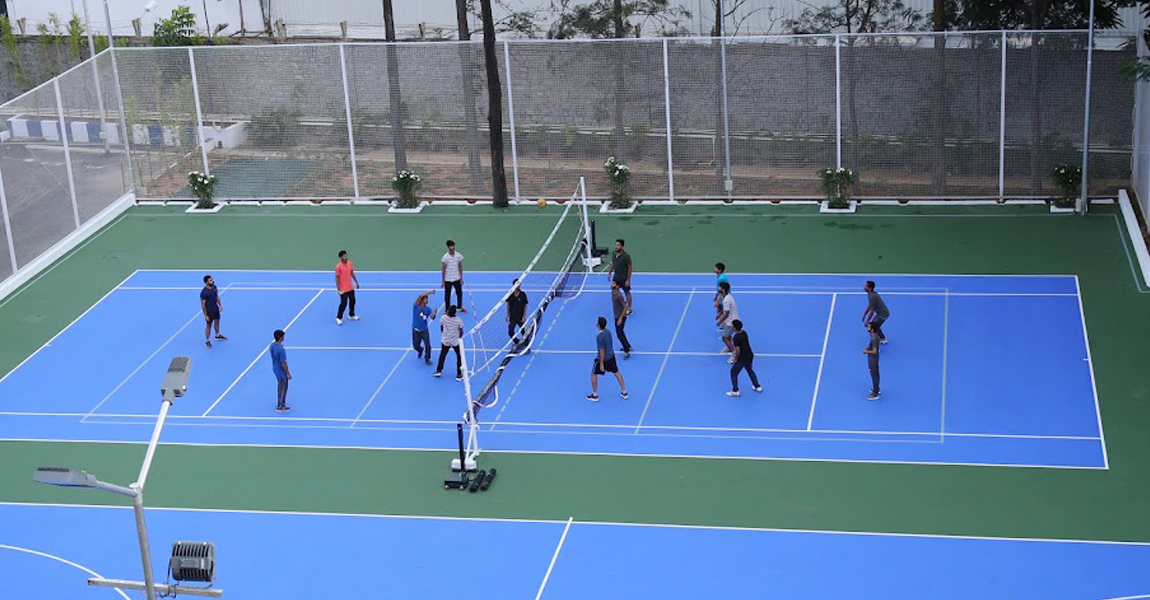

In [10]:
image = cv2.imread('iiitb_volleyball_court.jpg')
img_height, img_width, _ = image.shape
cv2_imshow(image)

The volley ball court at IIITB is depicted above.

In [11]:
results = object_detection(image, model, layer_name, object_id=labels.index('person'))
player_positions = [res['footstep'] for res in results]
print(f'The number of people who have been identified: {len(results)}')
print(f'Ground truth: 15')

The number of people who have been identified: 10
Ground truth: 15


In [12]:
# Manually detecting corners

A = (79, 422) # bottom-left
B = (943, 442) # bottom-right
C = (948, 287) # top-right
D = (231, 282) # top-left

court_boundaries = [A, B, C, D]
parallel_lines = [D, C, A, B]

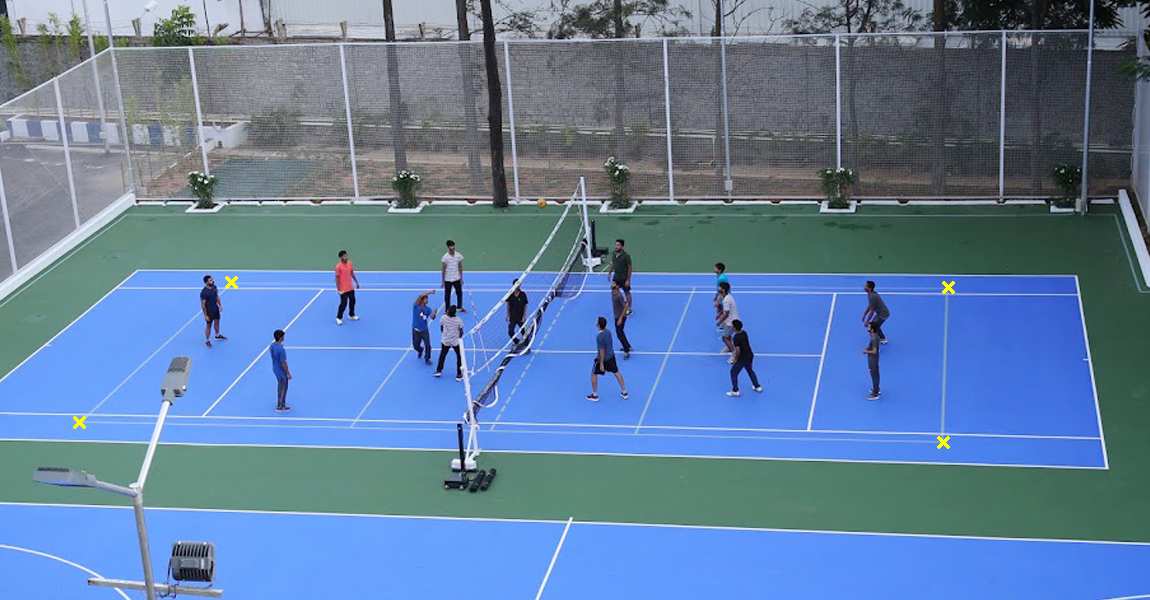

In [13]:
bounded_img = image.copy()
for vertex in court_boundaries:
    cv2.drawMarker(bounded_img, vertex, (0, 255, 255), markerType=cv2.MARKER_TILTED_CROSS , markerSize=10, thickness=2)
cv2_imshow(bounded_img)

Marking the corners of the court

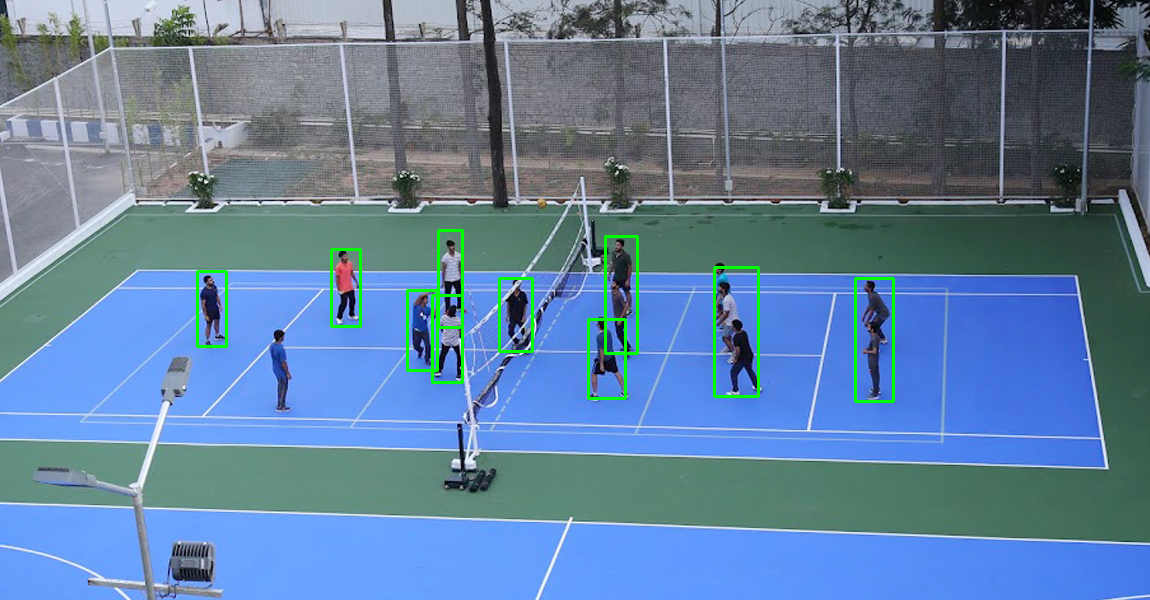

In [14]:
# Drawing bounding boxes around people who have been detected
bounding_boxes_img = image.copy()
for res in results:
    box = res['box']
    cv2.rectangle(bounding_boxes_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
cv2_imshow(bounding_boxes_img)

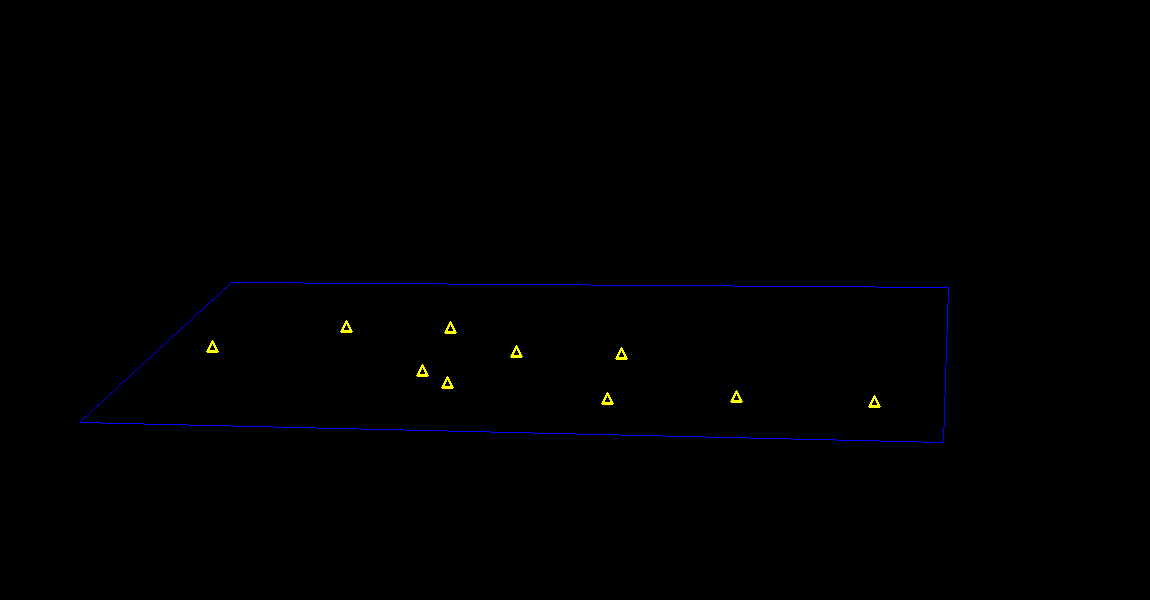

In [15]:
img_height, img_width, _ = image.shape
two_dim_map = np.zeros([img_height, img_width, 3], dtype=np.uint8)
two_dim_map.fill(0)
for res in player_positions:
    cv2.drawMarker(two_dim_map, res, (0, 255, 255), markerType=cv2.MARKER_TRIANGLE_UP , markerSize=10, thickness=2)
court_boundaries = np.array(court_boundaries).reshape((-1,1,2))
cv2.polylines(two_dim_map, sorted([court_boundaries]), True, (255, 0, 0))
cv2_imshow(two_dim_map)

The volleyball court is depicted graphically, with people represented as triangles.

In [16]:
map_width = img_width // 2
map_height = img_height // 2

pts1 = np.float32(parallel_lines)
pts2 = np.float32([[0, 0], [map_width, 0], [0, map_height], [map_width, map_height]])
perspective_mat = cv2.getPerspectiveTransform(pts1, pts2)
transformed = cv2.perspectiveTransform(np.float32([[res] for res in player_positions]), perspective_mat).astype(int)
transformed_player_positions = [res[0] for res in transformed]

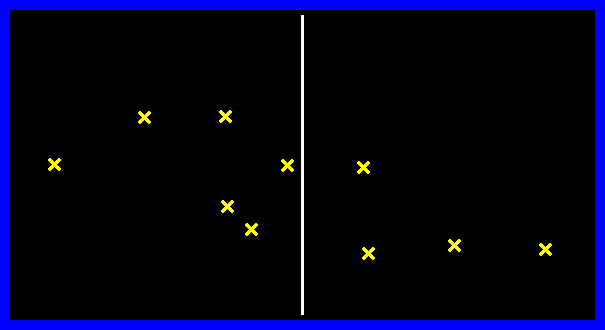

In [17]:
two_dim_map = np.zeros([map_height, map_width, 3], dtype=np.uint8)
two_dim_map.fill(0)
# Marking people with tilted cross marks.
for res in transformed_player_positions:
    cv2.drawMarker(two_dim_map, res, (0, 255, 255), markerType=cv2.MARKER_TILTED_CROSS , markerSize=10, thickness=2)
# The white line in the middle serves as a volleyball net.
cv2.line(two_dim_map, (map_width//2, map_height), (map_width//2, 0), (255, 255, 255), thickness=2)
# Black Border
padding_width = 5
padding_color = (0, 0, 0)
two_dim_map_with_padding = cv2.copyMakeBorder(two_dim_map, padding_width, padding_width, padding_width, padding_width, cv2.BORDER_CONSTANT, value=padding_color)
# Blue Border
border_width = 10
border_color = (255, 0, 0)
two_dim_map_with_border = cv2.copyMakeBorder(two_dim_map_with_padding, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value=border_color)
cv2_imshow(two_dim_map_with_border)

People are represented as titled cross marks on the volleyball court, which has been resized and graphically represented in warp perspective.

References:

1. https://data-flair.training/blogs/pedestrian-detection-python-opencv/
2. https://www.youtube.com/watch?v=Tm_7fGolVGE